🔍 데이터셋 폴더 내 클래스 확인:
['hammer', '.DS_Store', 'nipper']
✅ 클래스 목록: ['hammer', 'nipper']
💻 사용 중인 디바이스: mps
🚀 모델 학습 시작...
Epoch [1/10], Loss: 3.7791
Epoch [2/10], Loss: 0.3233
Epoch [3/10], Loss: 0.1037
Epoch [4/10], Loss: 0.0251
Epoch [5/10], Loss: 0.0049
Epoch [6/10], Loss: 0.0028
Epoch [7/10], Loss: 0.0019
Epoch [8/10], Loss: 0.0010
Epoch [9/10], Loss: 0.0005
Epoch [10/10], Loss: 0.0003
✅ 학습된 모델이 저장되었습니다: ./custom_cnn.pth


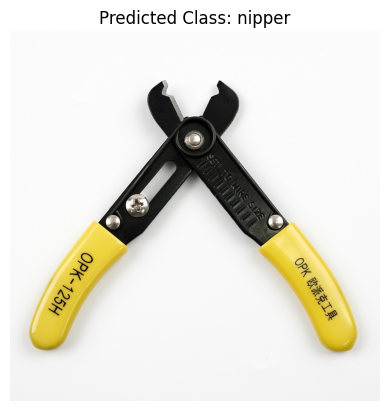

🔍 예측된 클래스: nipper


In [4]:
import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt

# 데이터 폴더 경로 설정 (macOS 로컬 경로)
data_dir = "./class"  # 적절한 로컬 경로로 변경

# 데이터 폴더 확인
print("🔍 데이터셋 폴더 내 클래스 확인:")
print(os.listdir(data_dir))

# 데이터 변환 (이미지 크기 조정, 정규화)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # VGG 스타일 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 클래스 목록 확인
class_names = train_dataset.classes
print(f"✅ 클래스 목록: {class_names}")

# CNN 모델 정의 (은닉층 2개 포함)
class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)  # 이미지 크기: 224x224 → 풀링 후: 56x56
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 클래스 개수 설정 및 모델 초기화
num_classes = len(class_names)
model = CustomCNN(num_classes)

# GPU 설정: macOS MPS 지원 확인
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"💻 사용 중인 디바이스: {device}")

model.to(device)

# 최적화 함수 및 손실 함수 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 설정
num_epochs = 10

print("🚀 모델 학습 시작...")
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        # 데이터를 MPS 디바이스로 이동하고 타입 일치시키기
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()          # 기울기 초기화
        outputs = model(images)        # 모델 예측 수행
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()                # 역전파 수행
        optimizer.step()               # 가중치 업데이트

        running_loss += loss.item()

    # 에포크별 손실 출력 (배치 크기 기반 평균 계산)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

# 모델 저장 경로 설정 (macOS 로컬 경로)
model_path = "./custom_cnn.pth"
torch.save(model.state_dict(), model_path)
print(f"✅ 학습된 모델이 저장되었습니다: {model_path}")

# 저장된 모델 불러오기 함수 정의
def load_model(model_path, num_classes):
    model = CustomCNN(num_classes)
    model.load_state_dict(torch.load(model_path))
    model.to(device)          # 모델을 MPS 또는 CPU로 이동
    model.eval()              # 평가 모드 활성화
    return model

# 저장된 모델 불러오기
loaded_model = load_model(model_path, num_classes)

# 샘플 이미지 예측 함수 정의 및 실행 (macOS 로컬 경로 사용)
def predict_sample(image_path, model):
    """
    저장된 CNN 모델을 사용하여 샘플 이미지를 예측하는 함수.
    """
    # 이미지 불러오기 및 전처리
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image_tensor = transform(image).unsqueeze(0).to(device)  # 배치 차원 추가 및 MPS 이동

    # 모델 예측 수행 (평가 모드에서 실행)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        _, predicted_class_idx = torch.max(output, dim=1)

    # 결과 시각화 및 출력
    plt.imshow(Image.open(image_path))
    plt.title(f"Predicted Class: {class_names[predicted_class_idx.item()]}")
    plt.axis('off')
    plt.show()

    print(f"🔍 예측된 클래스: {class_names[predicted_class_idx.item()]}")

# 샘플 이미지 경로 설정 및 예측 실행 (macOS 로컬 경로 사용)
sample_image_path = "./sample.jpg"
predict_sample(sample_image_path, loaded_model)
